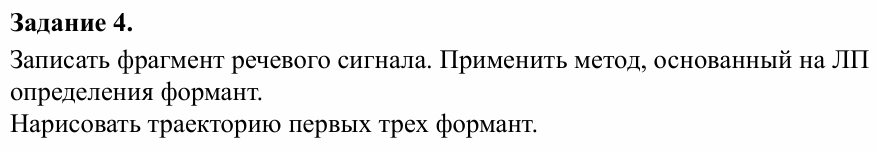

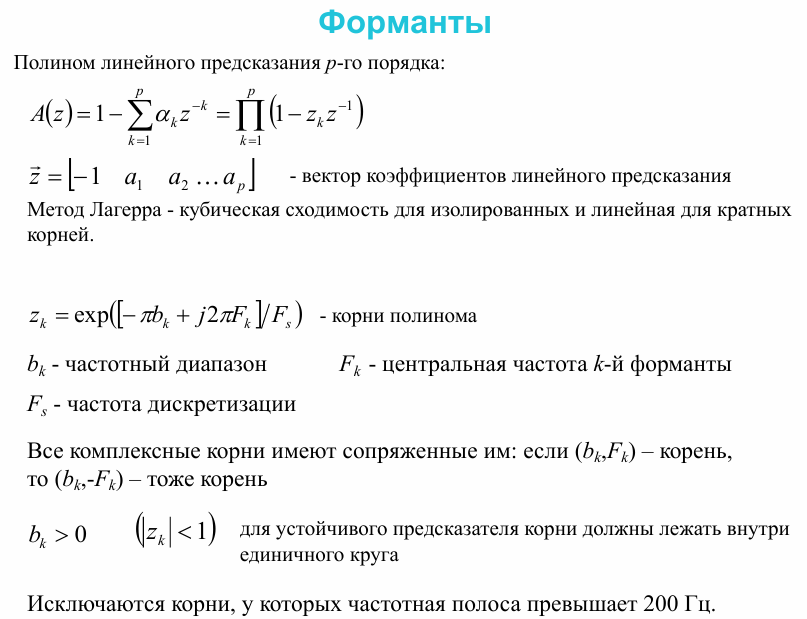

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

from scipy.signal import windows

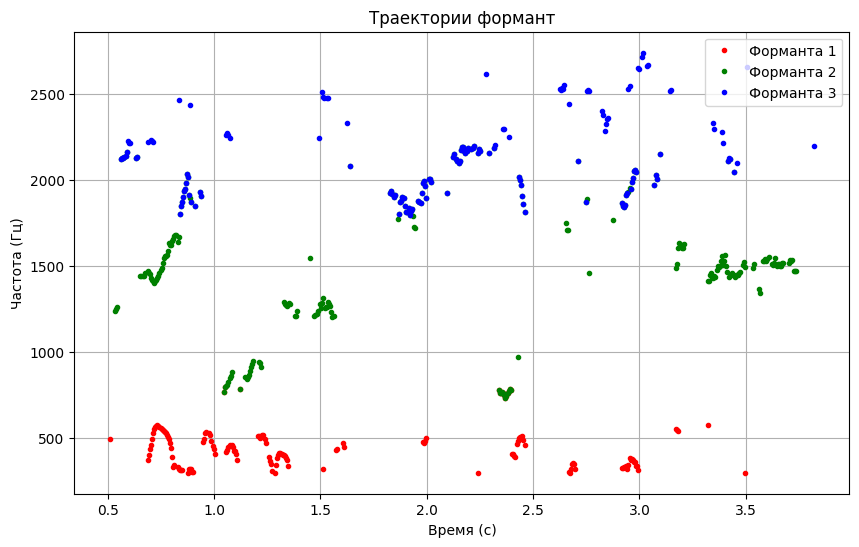

In [ ]:
def lpc(signal, sr, order, frame_length, hop_length):
    lpc_coeffs = []

    frames = librosa.util.frame(signal, frame_length=frame_length, hop_length=hop_length).T
    window = windows.hann(frame_length, sym=False)

    for frame in frames:
        coeffs = librosa.lpc(frame * window, order=order)
        lpc_coeffs.append(coeffs)

    return lpc_coeffs

def formants(lpc_coeffs, sr):
    formants = []

    for coef in lpc_coeffs:
        roots = np.roots(coef)
        roots = roots[np.imag(roots) > 0]

        F_k = np.arctan2(np.imag(roots), np.real(roots)) * (sr / (2 * np.pi))
        b_k = - (sr / np.pi) * np.log(np.abs(roots))

        mask = (b_k <= 200) & (F_k > 300) & (F_k < 2800)
        F_k = F_k[mask]
        F_k_1 = F_k[(F_k >= 300) & (F_k <= 800)]
        F_k_2 = F_k[(F_k >= 700) & (F_k <= 2200)]
        F_k_3 = F_k[(F_k >= 1800) & (F_k <= 2800)]

        padded = np.full(3, np.nan)

        if len(F_k_1) > 0:
            padded[0] = F_k_1[0]
        if len(F_k_2) > 0:
            padded[1] = F_k_2[0]
        if len(F_k_3) > 0:
            padded[2] = F_k_3[0]

        formants.append(padded)

    return np.array(formants)

order = int(2 + sr / 1000)
frame_length = int(0.025 * sr)
hop_length = int(0.005 * sr)

signal, sr = librosa.load('potter.wav')
lpc_coefs = lpc(signal, sr, order, frame_length, hop_length)
formants = formants(lpc_coefs, sr)
time = np.arange(formants.shape[0]) * hop_length / sr

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, formants[:, 0], marker='.', linestyle='None', color='r', label='Форманта 1')
ax.plot(time, formants[:, 1], marker='.', linestyle='None', color='g', label='Форманта 2')
ax.plot(time, formants[:, 2], marker='.', linestyle='None', color='b', label='Форманта 3')

plt.xlabel('Время (с)')
plt.ylabel('Частота (Гц)')
plt.title('Траектории формант')
plt.legend(loc='upper right')
plt.grid()
plt.show()